In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../estudo_inicial/base_de_dados_formatada.csv")
df = df[df.delta_t>0]
df = df.drop(columns=['ID','data_da_inscricao','data_do_obito','data_do_transplante','data_de_nascimento','data_do_evento'])
df.head()

,enxerto,uf,regiao,tipo_do_doador,uf_de_origem,sexo,grupo_sanguineo,cor,idade,obito_bin,transplante_bin,delta_t
0,CO,SP,Sudeste,NaN,NaN,M,O,Negra,15467.0,0,1,758.0
1,RI,PB,Nordeste,Doador Falecido,PB,M,O,Parda,18640.0,0,1,707.0
2,RI,PB,Nordeste,Doador Falecido,PB,M,A,Parda,21310.0,0,1,864.0
3,RI,PE,Nordeste,Doador Falecido,PE,M,O,Parda,23649.0,0,1,190.0
4,RI,PE,Nordeste,NaN,NaN,M,O,Branca,18651.0,0,1,1080.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183011 entries, 0 to 187250
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   enxerto          183011 non-null  object 
 1   uf               183011 non-null  object 
 2   regiao           183011 non-null  object 
 3   tipo_do_doador   166898 non-null  object 
 4   uf_de_origem     166898 non-null  object 
 5   sexo             183011 non-null  object 
 6   grupo_sanguineo  74274 non-null   object 
 7   cor              183011 non-null  object 
 8   idade            183011 non-null  float64
 9   obito_bin        183011 non-null  int64  
 10  transplante_bin  183011 non-null  int64  
 11  delta_t          183011 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 18.2+ MB


In [4]:
np.unique(df.tipo_do_doador.dropna().values,return_counts=True)

(array(['Doador Falecido', 'Doador Vivo'], dtype=object),
 array([159293,   7605]))

In [5]:
df_bin = df.fillna(0)

bin_cols = [
    "enxerto",
    "uf",
    "regiao",
    "tipo_do_doador",
    "uf_de_origem",
    "sexo",
    "grupo_sanguineo",
    "cor",
]

for col in bin_cols:

    
    # converting to binary data
    df_one = pd.get_dummies(
        df[col],
    )

    # Use the .replace() method to map True/False to 1/0


    df_one[df_one==True] = 1
    df_one[df_one==False] = 0

    # Recolocando NaN
    df_one.loc[df[col].isnull()] = None

    # Renomeando colunas
    new_columns = [
        col + "_" + category.strip().replace(" ", "_") for category in df_one.columns
    ]

    df_one.columns = new_columns

    df_aux = pd.concat([df_bin, df_one],axis=1)

    df_aux = df_aux.drop(columns=[col])

    df_bin = df_aux

df_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183011 entries, 0 to 187250
Data columns (total 89 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   idade                           183011 non-null  float64
 1   obito_bin                       183011 non-null  int64  
 2   transplante_bin                 183011 non-null  int64  
 3   delta_t                         183011 non-null  float64
 4   enxerto_CA                      183011 non-null  object 
 5   enxerto_CO                      183011 non-null  object 
 6   enxerto_CO_FI                   183011 non-null  object 
 7   enxerto_CO_PU                   183011 non-null  object 
 8   enxerto_CO_RI                   183011 non-null  object 
 9   enxerto_FI                      183011 non-null  object 
 10  enxerto_FI_PA                   183011 non-null  object 
 11  enxerto_FI_RI                   183011 non-null  object 
 12  enxerto_Multivisceral

In [6]:
df_nan = df_bin[df_bin.isna().any(axis=1)]
df_treated = df_bin[df_bin.notna().all(axis=1)]

print("Numero de nan: {}".format(len(df_nan)))
print("Numero de completos: {}".format(len(df_treated)))

Numero de nan: 124440
Numero de completos: 58571


In [7]:
df_treated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58571 entries, 1 to 187240
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idade                           58571 non-null  float64
 1   obito_bin                       58571 non-null  int64  
 2   transplante_bin                 58571 non-null  int64  
 3   delta_t                         58571 non-null  float64
 4   enxerto_CA                      58571 non-null  object 
 5   enxerto_CO                      58571 non-null  object 
 6   enxerto_CO_FI                   58571 non-null  object 
 7   enxerto_CO_PU                   58571 non-null  object 
 8   enxerto_CO_RI                   58571 non-null  object 
 9   enxerto_FI                      58571 non-null  object 
 10  enxerto_FI_PA                   58571 non-null  object 
 11  enxerto_FI_RI                   58571 non-null  object 
 12  enxerto_Multivisceral           5857

<Axes: >

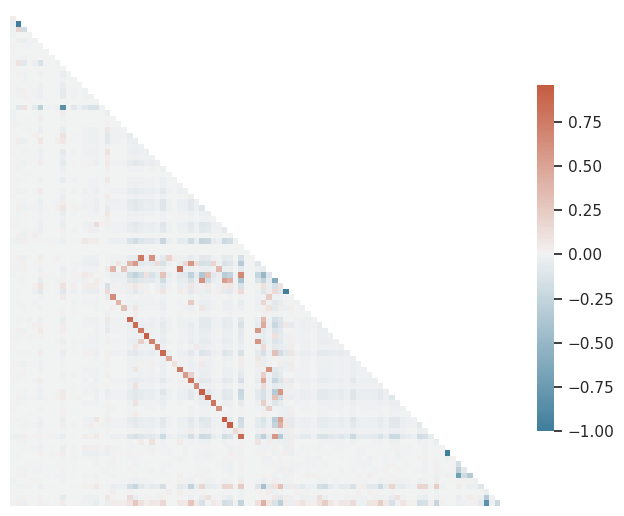

In [8]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = df_treated.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr.fillna(0),
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    # linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=False, yticklabels=False
    
)

In [9]:
corr_abs = ((corr.fillna(0)) ** 2) ** 0.5
pd.DataFrame(
    {
        "Atributo": corr_abs.obito_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.obito_bin.sort_values(ascending=False).values,
    }
).head(12)

,Atributo,Correlação
0,transplante_bin,1.000000
1,obito_bin,1.000000
2,delta_t,0.184999
3,enxerto_RI,0.090222
4,enxerto_FI,0.088587
5,idade,0.029518
6,enxerto_CO,0.029000
7,uf_DF,0.025975
8,uf_de_origem_SP,0.025469
9,uf_SP,0.024104


In [10]:
pd.DataFrame(
    {
        "Atributo": corr_abs.transplante_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.transplante_bin.sort_values(ascending=False).values,
    }
).head(12)

,Atributo,Correlação
0,transplante_bin,1.000000
1,obito_bin,1.000000
2,delta_t,0.184999
3,enxerto_RI,0.090222
4,enxerto_FI,0.088587
5,idade,0.029518
6,enxerto_CO,0.029000
7,uf_DF,0.025975
8,uf_de_origem_SP,0.025469
9,uf_SP,0.024104


In [11]:
pd.DataFrame(
    {
        "Atributo": corr_abs.delta_t.sort_values(ascending=False).index,
        "Correlação": corr_abs.delta_t.sort_values(ascending=False).values,
    }
).head(13)

,Atributo,Correlação
0,delta_t,1.000000
1,transplante_bin,0.184999
2,obito_bin,0.184999
3,uf_de_origem_BA,0.013105
4,uf_de_origem_RJ,0.012281
5,uf_BA,0.011927
6,uf_RJ,0.010612
7,uf_de_origem_MG,0.009616
8,idade,0.008603
9,enxerto_CA,0.007929


Total explained variance ratio: 0.9999999110978196


Text(0.5, 1.0, 'PCA')

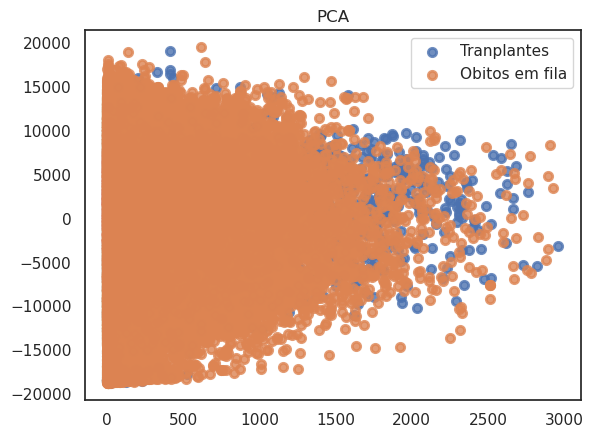

In [13]:
from sklearn.decomposition import PCA

X = df_treated.drop(columns=['delta_t', 'obito_bin', 'transplante_bin'])
y = df_treated.delta_t

pca = PCA(n_components=1)
X_r = pca.fit(X).transform(X)

print(
    "Total explained variance ratio: %s"
    % str(sum(pca.explained_variance_ratio_))
)

target_names = ["Óbito em fila", "Transplante"]
lw = 2

plt.scatter(
    y[df_treated['transplante_bin'] == 0],
    X_r[df_treated['transplante_bin'] == 0],
    alpha=0.8,
    lw=lw,
    label="Tranplantes",
)

plt.scatter(
    y[df_treated['transplante_bin'] == 1],
    X_r[df_treated['transplante_bin'] == 1],
    alpha=0.8,
    lw=lw,
    label="Obitos em fila",
)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

In [15]:
import numpy as np
from sklearn.impute import KNNImputer


imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_bin_input = imputer.fit_transform(df_bin)

In [17]:
df_bin_input = pd.DataFrame(df_bin_input,columns=df_bin.columns)

In [23]:
len(df_bin_input)

183011

<Axes: >

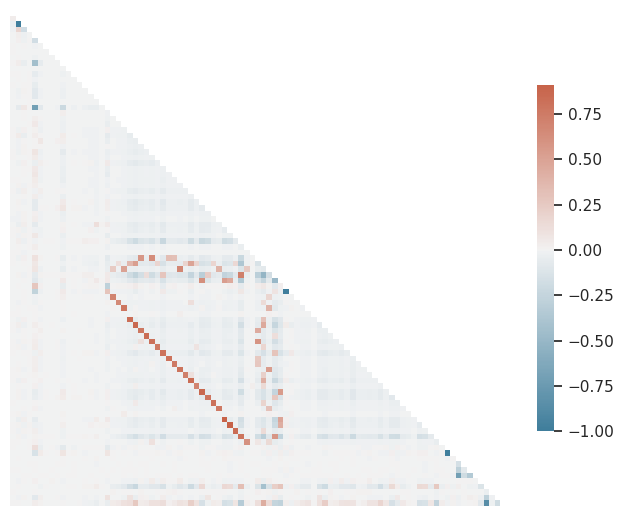

In [18]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = df_bin_input.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr.fillna(0),
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    # linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=False, yticklabels=False
    
)

In [19]:
corr_abs = ((corr.fillna(0)) ** 2) ** 0.5
pd.DataFrame(
    {
        "Atributo": corr_abs.obito_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.obito_bin.sort_values(ascending=False).values,
    }
).head(12)


,Atributo,Correlação
0,transplante_bin,1.000000
1,obito_bin,1.000000
2,delta_t,0.175746
3,enxerto_RI,0.062318
4,uf_CE,0.040307
5,enxerto_FI,0.037534
6,idade,0.032010
7,uf_de_origem_RS,0.030033
8,uf_RS,0.029011
9,enxerto_CA,0.028676


In [20]:

pd.DataFrame(
    {
        "Atributo": corr_abs.transplante_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.transplante_bin.sort_values(ascending=False).values,
    }
).head(12)


,Atributo,Correlação
0,transplante_bin,1.000000
1,obito_bin,1.000000
2,delta_t,0.175746
3,enxerto_RI,0.062318
4,uf_CE,0.040307
5,enxerto_FI,0.037534
6,idade,0.032010
7,uf_de_origem_RS,0.030033
8,uf_RS,0.029011
9,enxerto_CA,0.028676


In [21]:

pd.DataFrame(
    {
        "Atributo": corr_abs.delta_t.sort_values(ascending=False).index,
        "Correlação": corr_abs.delta_t.sort_values(ascending=False).values,
    }
).head(13)

,Atributo,Correlação
0,delta_t,1.000000
1,obito_bin,0.175746
2,transplante_bin,0.175746
3,uf_de_origem_SC,0.009138
4,idade,0.007738
5,uf_SC,0.007393
6,uf_BA,0.005858
7,uf_AM,0.005162
8,uf_de_origem_AM,0.005149
9,uf_SP,0.005028


Total explained variance ratio: 0.9999999167824363


Text(0.5, 1.0, 'PCA')

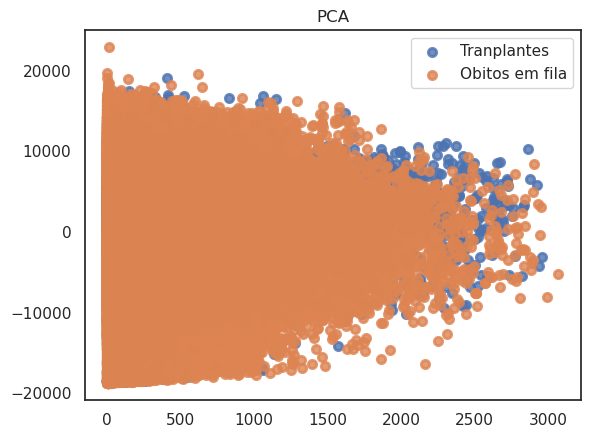

In [22]:
from sklearn.decomposition import PCA

X = df_bin_input.drop(columns=['delta_t', 'obito_bin', 'transplante_bin'])
y = df_bin_input.delta_t

pca = PCA(n_components=1)
X_r = pca.fit(X).transform(X)

print(
    "Total explained variance ratio: %s"
    % str(sum(pca.explained_variance_ratio_))
)

target_names = ["Óbito em fila", "Transplante"]
lw = 2

plt.scatter(
    y[df_bin_input['transplante_bin'] == 0],
    X_r[df_bin_input['transplante_bin'] == 0],
    alpha=0.8,
    lw=lw,
    label="Tranplantes",
)

plt.scatter(
    y[df_bin_input['transplante_bin'] == 1],
    X_r[df_bin_input['transplante_bin'] == 1],
    alpha=0.8,
    lw=lw,
    label="Obitos em fila",
)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")

In [24]:
df_bin_input.to_csv("df_bin_input.csv")

In [27]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(300,300,300),max_iter=500).fit(X_train, y_train)
regr.score(X_test, y_test)